In [573]:
import pandas as pd
import numpy as np
import spacy
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to make jupyter print all outputs, not just the last one
import pickle
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF
import re

In [574]:
data = pd.read_csv('survey.csv')

In [575]:
data.head()

,Timestamp,Age,Gender,2. a) The company offers high-quality products and services.,b) Offers products and services that are a good value for the money.,3. a) The company regularly introduces new and innovative services.,b) The company adapts well to changes in customer preferences.,4. a) The company is financially stable.,b) The company's financial performance is impressive.,5. a) The company contributes positively to the welfare of the community.,...,b) The company's leadership effectively guides the organization.,9. a) I read online reviews before deciding about a hotel.,b) I engage with the company's online content and share positive or negative experiences.,10. a) I trust online reviews and ratings when choosing a hotel,b) I have confidence in the promises made by the company.,c) The level of trust I have in online reviews influence my final hotel selection?,11. It is very important for you that a hotel respond to online reviews and customer feedback?,12. a) The trust in the company's reputation impact your final decision to choose its products/services over others?,b) The positive or negative reviews from online sources influence your decision to engage with the company's offerings or not.,c) You are willing to pay a premium for the quality and reputation associated with the company.
0,2023/06/01 11:50:14 AM GMT+3,18-25,Female,5,5,4,4,3,3,4,...,4,5,4,5,4,5,5,4,4,4
1,2023/06/01 13:32:04 AM GMT+3,18-25,Female,2,1,2,2,3,3,3,...,2,4,4,4,4,5,5,4,4,4
2,2023/06/01 02:36:33 PM GMT+3,18-25,Female,4,4,4,4,3,3,4,...,4,5,4,5,4,5,5,5,5,5
3,2023/06/01 02:48:09 PM GMT+3,26-40,Female,5,4,4,4,3,3,4,...,4,5,4,5,4,5,5,5,5,5
4,2023/06/02 02:31:48 PM GMT+3,41-60,Male,4,4,4,4,3,3,4,...,4,3,4,4,4,4,4,4,4,4


In [576]:
#input_file = "MPsurvey.csv"
#output_file = "survey.csv"

#with open(input_file, "r") as infile, open(output_file, "w") as outfile:
#    for line in infile:
        # Remove double quotes from each line
#        clean_line = line.replace('"', '')
#        outfile.write(clean_line)

In [577]:
column_mapping = {
    '2.  a) The company offers high-quality products and services. ': 'PR/SERV1',
    'b) Offers products and services that are a good value for the money.  ': 'PR/SERV2',
    '3. a)  The company regularly introduces new and innovative services.': 'Innov1',
    ' b)   The company adapts well to changes in customer preferences.': 'Innov2',
    '4. a)  The company is financially stable. ': 'F1',
    "b)  The company's financial performance is impressive.": 'F2',
    '5. a)  The company contributes positively to the welfare of the community.': 'Sust1',
    'b) The company is committed to environmentally sustainable practices. ': 'Sust2',
    '6. a)The company maintains a positive work environment for its employees.': 'W1',
    'b)  The company values the well-being and happiness of its employees.': 'W2',
    '7. a)The company pays close attention to customer needs and preferences.': 'Cust1',
    'b) Customers generally express high levels of satisfaction with the company.': 'Cust2',
    '8. a) The company\'s future goals and direction are clear.': 'VLD1',
    'b)   The company\'s leadership effectively guides the organization.': 'VLD2',
    '9.  a) I  read online reviews before deciding about a hotel.': 'EWOM1',
    'b) I engage with the company\'s online content and share positive or negative  experiences.': 'EWOM2',
    '10. a) I trust online reviews and ratings when choosing a hotel': 'Trust1',
    'b) I have confidence in the promises made by the company.': 'Trust2',
    'c)  The level of trust I have in online reviews influence my final hotel selection?': 'Trust3',
    '11. It is very important  for you that a hotel respond to online reviews and customer feedback?': 'Resp1',
    '12. a) The trust in the company\'s reputation impact your final decision to choose its products/services over others?': 'Decis1',
    'b)  The  positive or negative reviews from online sources influence your decision to engage with the company\'s offerings or not.': 'Decis2',
    'c) You are willing to pay a premium for the quality and reputation associated with the company.': 'Decis3'
}

In [578]:

# Rename columns using the mapping
data.rename(columns=column_mapping, inplace=True)

In [579]:
# Rename the column with forward slash
data.rename(columns={'PR/SERV1': 'PR_SERV1', 'PR/SERV2': 'PR_SERV2'}, inplace=True)


In [580]:
# Check for missing values in the entire dataset
missing_values = data.isna().sum()
print(missing_values)

Timestamp    0
Age          0
Gender       0
PR_SERV1     0
PR_SERV2     0
Innov1       0
Innov2       0
F1           0
F2           0
Sust1        0
Sust2        0
W1           0
W2           0
Cust1        0
Cust2        0
VLD1         0
VLD2         0
EWOM1        0
EWOM2        0
Trust1       0
Trust2       0
Trust3       0
Resp1        0
Decis1       0
Decis2       0
Decis3       0
dtype: int64


In [581]:
# Assuming your DataFrame is named 'data'
data['Decis3'] = data['Decis3'].astype(int)

In [582]:
data.head()

,Timestamp,Age,Gender,PR_SERV1,PR_SERV2,Innov1,Innov2,F1,F2,Sust1,...,VLD2,EWOM1,EWOM2,Trust1,Trust2,Trust3,Resp1,Decis1,Decis2,Decis3
0,2023/06/01 11:50:14 AM GMT+3,18-25,Female,5,5,4,4,3,3,4,...,4,5,4,5,4,5,5,4,4,4
1,2023/06/01 13:32:04 AM GMT+3,18-25,Female,2,1,2,2,3,3,3,...,2,4,4,4,4,5,5,4,4,4
2,2023/06/01 02:36:33 PM GMT+3,18-25,Female,4,4,4,4,3,3,4,...,4,5,4,5,4,5,5,5,5,5
3,2023/06/01 02:48:09 PM GMT+3,26-40,Female,5,4,4,4,3,3,4,...,4,5,4,5,4,5,5,5,5,5
4,2023/06/02 02:31:48 PM GMT+3,41-60,Male,4,4,4,4,3,3,4,...,4,3,4,4,4,4,4,4,4,4


In [583]:
# Print the data types of each column
data_types = data.dtypes
print(data_types)

Timestamp    object
Age          object
Gender       object
PR_SERV1      int64
PR_SERV2      int64
Innov1        int64
Innov2        int64
F1            int64
F2            int64
Sust1         int64
Sust2         int64
W1            int64
W2            int64
Cust1         int64
Cust2         int64
VLD1          int64
VLD2          int64
EWOM1         int64
EWOM2         int64
Trust1        int64
Trust2        int64
Trust3        int64
Resp1         int64
Decis1        int64
Decis2        int64
Decis3        int32
dtype: object


In [584]:

# Define the dimensions of Corporate Reputation
reputation_dimensions = ['PR_SERV1', 'PR_SERV2', 'Innov1', 'Innov2', 'F1', 'F2', 'Sust1' , 'Sust2' , 'W1' , 'W2',  'Cust1', 'Cust2', 'VLD1', 'VLD2']  

# Calculate the average score for each row
data['CorpRep'] = data[reputation_dimensions].mean(axis=1)

# Print the updated DataFrame
print(data[['CorpRep'] + reputation_dimensions])

      CorpRep  PR_SERV1  PR_SERV2  Innov1  Innov2  F1  F2  Sust1  Sust2  W1  \
0    4.000000         5         5       4       4   3   3      4      4   4   
1    2.428571         2         1       2       2   3   3      3      3   3   
2    3.857143         4         4       4       4   3   3      4      4   4   
3    4.071429         5         4       4       4   3   3      4      5   4   
4    3.785714         4         4       4       4   3   3      4      4   4   
..        ...       ...       ...     ...     ...  ..  ..    ...    ...  ..   
199  4.357143         5         5       4       4   3   3      5      5   5   
200  4.142857         4         5       4       4   3   3      4      4   5   
201  3.785714         4         4       4       4   3   3      4      4   4   
202  3.857143         4         4       4       4   3   3      4      4   4   
203  4.071429         5         4       4       4   3   3      4      5   4   

     W2  Cust1  Cust2  VLD1  VLD2  
0     3      5 

In [585]:
trust_dimensions = ['Trust1', 'Trust2', 'Trust3']  # 

data['Trust'] = data[trust_dimensions].mean(axis=1)

print(data[['Trust'] + trust_dimensions])

        Trust  Trust1  Trust2  Trust3
0    4.666667       5       4       5
1    4.333333       4       4       5
2    4.666667       5       4       5
3    4.666667       5       4       5
4    4.000000       4       4       4
..        ...     ...     ...     ...
199  4.666667       5       4       5
200  4.666667       5       4       5
201  4.000000       4       4       4
202  4.666667       5       4       5
203  4.666667       5       4       5

[204 rows x 4 columns]


In [586]:
ewom_dimensions = ['EWOM1', 'EWOM2']  # Add all relevant dimensions

data['eWOM'] = data[ewom_dimensions].mean(axis=1)

print(data[['eWOM'] + ewom_dimensions])


     eWOM  EWOM1  EWOM2
0     4.5      5      4
1     4.0      4      4
2     4.5      5      4
3     4.5      5      4
4     3.5      3      4
..    ...    ...    ...
199   4.5      5      4
200   4.0      4      4
201   3.5      3      4
202   4.5      5      4
203   4.5      5      4

[204 rows x 3 columns]


In [587]:
responsiveness_dimensions = ['Resp1']  # Add all relevant dimensions

data['Responsiveness'] = data[responsiveness_dimensions].mean(axis=1)

print(data[['Responsiveness'] + responsiveness_dimensions])


     Responsiveness  Resp1
0               5.0      5
1               5.0      5
2               5.0      5
3               5.0      5
4               4.0      4
..              ...    ...
199             5.0      5
200             5.0      5
201             4.0      4
202             5.0      5
203             5.0      5

[204 rows x 2 columns]


In [588]:
decision_dimensions = ['Decis1', 'Decis2', 'Decis3']  # Add all relevant dimensions

data['Decision_Making'] = data[decision_dimensions].mean(axis=1)

print(data[['Decision_Making'] + decision_dimensions])


     Decision_Making  Decis1  Decis2  Decis3
0                4.0       4       4       4
1                4.0       4       4       4
2                5.0       5       5       5
3                5.0       5       5       5
4                4.0       4       4       4
..               ...     ...     ...     ...
199              5.0       5       5       5
200              5.0       5       5       5
201              4.0       4       4       4
202              5.0       5       5       5
203              5.0       5       5       5

[204 rows x 4 columns]


In [589]:
data.head()

,Timestamp,Age,Gender,PR_SERV1,PR_SERV2,Innov1,Innov2,F1,F2,Sust1,...,Trust3,Resp1,Decis1,Decis2,Decis3,CorpRep,Trust,eWOM,Responsiveness,Decision_Making
0,2023/06/01 11:50:14 AM GMT+3,18-25,Female,5,5,4,4,3,3,4,...,5,5,4,4,4,4.000000,4.666667,4.5,5.0,4.0
1,2023/06/01 13:32:04 AM GMT+3,18-25,Female,2,1,2,2,3,3,3,...,5,5,4,4,4,2.428571,4.333333,4.0,5.0,4.0
2,2023/06/01 02:36:33 PM GMT+3,18-25,Female,4,4,4,4,3,3,4,...,5,5,5,5,5,3.857143,4.666667,4.5,5.0,5.0
3,2023/06/01 02:48:09 PM GMT+3,26-40,Female,5,4,4,4,3,3,4,...,5,5,5,5,5,4.071429,4.666667,4.5,5.0,5.0
4,2023/06/02 02:31:48 PM GMT+3,41-60,Male,4,4,4,4,3,3,4,...,4,4,4,4,4,3.785714,4.000000,3.5,4.0,4.0


In [608]:
# Print the data types of each column
data_types = data.dtypes
print(data_types)

Timestamp                    object
Age                          object
Gender                       object
PR_SERV1                      int64
PR_SERV2                      int64
Innov1                        int64
Innov2                        int64
F1                            int64
F2                            int64
Sust1                         int64
Sust2                         int64
W1                            int64
W2                            int64
Cust1                         int64
Cust2                         int64
VLD1                          int64
VLD2                          int64
EWOM1                         int64
EWOM2                         int64
Trust1                        int64
Trust2                        int64
Trust3                        int64
Resp1                         int64
Decis1                        int64
Decis2                        int64
Decis3                        int32
CorpRep                     float64
Trust                       

In [590]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
PR_SERV1,204.0,4.205882,0.816556,2.000000,4.000000,4.000000,5.000000,5.000000
PR_SERV2,204.0,4.053922,1.032494,1.000000,4.000000,4.000000,5.000000,5.000000
Innov1,204.0,3.838235,0.560004,2.000000,4.000000,4.000000,4.000000,5.000000
Innov2,204.0,3.823529,0.559940,2.000000,4.000000,4.000000,4.000000,4.000000
F1,204.0,3.004902,0.070014,3.000000,3.000000,3.000000,3.000000,4.000000
F2,204.0,3.009804,0.098771,3.000000,3.000000,3.000000,3.000000,4.000000
Sust1,204.0,4.093137,0.512073,3.000000,4.000000,4.000000,4.000000,5.000000
Sust2,204.0,4.426471,0.642873,3.000000,4.000000,5.000000,5.000000,5.000000
W1,204.0,4.078431,0.425453,3.000000,4.000000,4.000000,4.000000,5.000000
W2,204.0,3.828431,0.815476,3.000000,3.000000,4.000000,5.000000,5.000000


In [591]:
import pandas as pd
from scipy import stats
from pingouin import reliability

# Define constructs and their corresponding items
constructs = {
    #'Corp_rep':  ['PR_SERV1', 'PR_SERV2', 'Innov1', 'Innov2', 'F1', 'F2', 'Sust1' , 'Sust2' , 'W1' , 'W2',  'Cust1', 'Cust2', 'VLD1', 'VLD2'], 
    'PR_SERV': ['PR_SERV1', 'PR_SERV2'],
    'Innov': ['Innov1', 'Innov2'],
    'F': ['F1','F2'],
    'Sust': ['Sust1', 'Sust2'],
    'W': ['W1','W2'],
    'Cust': ['Cust1', 'Cust2'],
    'VLD': ['VLD1', 'VLD2'],
    'Trust': ['Trust1','Trust2','Trust3'],
    'eWOM': ['EWOM1', 'EWOM2'],
    'Responsiveness': ['Resp1','EWOM1'],
    'Decision_Making': ['Decis1', 'Decis2', 'Decis3']
}

# Create a DataFrame to store Cronbach's alpha values
cronbach_alpha_df = pd.DataFrame(columns=['Construct', 'CronbachAlpha'])

# Calculate Cronbach's alpha for each construct
for construct, items in constructs.items():
    construct_data = data[items]
    cronbach_alpha = reliability.cronbach_alpha(construct_data)
    cronbach_alpha_df = cronbach_alpha_df.append({'Construct': construct, 'CronbachAlpha': cronbach_alpha}, ignore_index=True)

# Print the Cronbach's alpha values
print(cronbach_alpha_df)


          Construct                             CronbachAlpha
0           PR_SERV      (0.8747834131731831, [0.835, 0.905])
1             Innov      (0.9882545433296297, [0.985, 0.991])
2                 F  (-0.013266998341625147, [-0.335, 0.231])
3              Sust       (0.8019700214132759, [0.739, 0.85])
4                 W        (0.6436051801234994, [0.53, 0.73])
5              Cust      (0.8611285115404985, [0.817, 0.895])
6               VLD   (0.026347497790986996, [-0.283, 0.261])
7             Trust      (0.5862811583577726, [0.477, 0.676])
8              eWOM      (0.4359083795703518, [0.257, 0.572])
9    Responsiveness      (0.6210609333744808, [0.501, 0.712])
10  Decision_Making      (0.8435529758245525, [0.802, 0.877])


C:\Users\olgal\AppData\Local\Temp\ipykernel_16128\3010779661.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cronbach_alpha_df = cronbach_alpha_df.append({'Construct': construct, 'CronbachAlpha': cronbach_alpha}, ignore_index=True)
C:\Users\olgal\AppData\Local\Temp\ipykernel_16128\3010779661.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cronbach_alpha_df = cronbach_alpha_df.append({'Construct': construct, 'CronbachAlpha': cronbach_alpha}, ignore_index=True)
C:\Users\olgal\AppData\Local\Temp\ipykernel_16128\3010779661.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cronbach_alpha_df = cronbach_alpha_df.append({'Construct': construct, 'CronbachAlpha': cronbach_alpha}, ignore_index=True)
C:\Users\olgal\AppData

In [615]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


In [616]:
X = data[['CorpRep', 'eWOM']]
y = data['Decision_Making']


In [617]:
regressor = LinearRegression()
regressor.fit(X, y)


LinearRegression()

In [618]:
r_squared = regressor.score(X, y)


In [619]:
print("R-squared:", r_squared)


R-squared: 0.38532174438321587


In [597]:
# Calculate average scores for each dimension
data['Avg_PR_SER'] = data[['PR_SERV1', 'PR_SERV2']].mean(axis=1)
data['Avg_Innovation'] = data[['Innov1', 'Innov2']].mean(axis=1)
data['Avg_F'] = data[['F1', 'F2']].mean(axis=1)
data['Avg_Sustainability'] = data[['Sust1', 'Sust2']].mean(axis=1)
data['Avg_Workplace'] = data[['W1', 'W2']].mean(axis=1)
data['Avg_Customer_Orientation'] = data[['Cust1', 'Cust2']].mean(axis=1)
data['Avg_Vision'] = data[['VLD1', 'VLD2']].mean(axis=1)

In [598]:
import semopy
from semopy import Model

In [620]:
import semopy

# Define the SEM model
desc = '''
    # Latent variables
    CR =~ PR_SERV1 + PR_SERV2 + Innov1 + Innov2 + Sust1 + Sust2 + W1 + W2 + Cust1 + Cust2
    CT =~ Trust1 + Trust2 + Trust3
    EI =~ EWOM1 + EWOM2
    DM =~ Decis1 + Decis2 + Decis3
    RS =~ Resp1

    # Mediation: responsiveness on decision making
    RS ~ DM

    # eWOM (EI) positively affects Consumer Trust (CT) and Corporate Reputation (CR)
    CT ~ EI
    CR ~ EI

    # Moderation: Consumer Trust (CT) moderates the relationship between Corporate Reputation (CR) and Decision-Making (DM)
    DM ~ CR + CT + CR*CT
'''

In [621]:
import networkx as nx
import matplotlib.pyplot as plt

In [622]:
# Fit the model
model = semopy.Model(desc)
results = model.fit(data)
print(results)

Name of objective: MLW
Optimization method: SLSQP
Optimization successful.
Optimization terminated successfully
Objective value: 17.903
Number of iterations: 54
Params: 1.376 0.811 0.829 0.499 0.658 0.336 0.354 1.147 0.826 0.040 0.676 0.216 1.212 1.128 0.410 0.765 1.071 0.028 0.625 0.098 0.000 0.217 0.214 0.068 0.201 0.074 0.097 0.209 0.000 0.092 0.197 0.606 0.130 0.009 0.034 0.149 0.072 0.003 0.016 0.103 0.229 0.071 0.220


In [623]:
# Inspect the estimated model parameters
ins = model.inspect()
print(ins)

        lval  op      rval      Estimate   Std. Err    z-value   p-value
0         RS   ~        DM  4.103664e-01   0.085202   4.816398  0.000001
1         CT   ~        EI  7.652795e-01   0.046974  16.291497       0.0
2         CR   ~        EI  1.070737e+00   0.097932  10.933499       0.0
3         DM   ~        CR  2.830994e-02   0.049915   0.567163  0.570603
4         DM   ~        CT  6.246927e-01   0.100795   6.197684       0.0
5   PR_SERV1   ~        CR  1.000000e+00          -          -         -
6   PR_SERV2   ~        CR  1.376403e+00   0.082099  16.765219       0.0
7     Innov1   ~        CR  8.111515e-01   0.041494  19.548629       0.0
8     Innov2   ~        CR  8.285670e-01   0.040605  20.405366       0.0
9      Sust1   ~        CR  4.987612e-01   0.047111   10.58691       0.0
10     Sust2   ~        CR  6.578444e-01    0.05824  11.295487       0.0
11        W1   ~        CR  3.355247e-01   0.041047   8.174218       0.0
12        W2   ~        CR  3.535979e-01    0.08328

In [637]:
# Extract factor loadings (if not already done)
factor_loadings = results.loadings

# Extract residual variances
residual_variances = results.residual_variances

# Calculate CR and AVE
latent_constructs = {
    'CorpRep': ['PR_SERV1', 'PR_SERV2', 'Innov1', 'Innov2', 'Sust1' , 'Sust2' , 'W1' , 'W2',  'Cust1', 'Cust2'],
    'Trust': ['Trust1', 'Trust2', 'Trust3'],
    'eWOM': ['EWOM1', 'EWOM2'],
    'Responsiveness': ['Resp1','EWOM1'],
    'Decision_Making': ['Decis1', 'Decis2', 'Decis3']
    # Add other latent constructs and their observed variables here
}

cr_values = {}
ave_values = {}

for latent, observed in latent_constructs.items():
    # Calculate CR for each latent construct
    factor_loading_squared_sum = (factor_loadings[observed]**2).sum(axis=0)
    residual_variance_sum = residual_variances[observed].sum(axis=0)
    cr = (factor_loading_squared_sum) / (factor_loading_squared_sum + residual_variance_sum)
    cr_values[latent] = cr

    # Calculate AVE for each latent construct
    ave = factor_loading_squared_sum / len(observed)
    ave_values[latent] = ave

# Print CR and AVE values for each latent construct
for latent, cr in cr_values.items():
    print(f'CR for {latent}: {cr:.4f}')

for latent, ave in ave_values.items():
    print(f'AVE for {latent}: {ave:.4f}')


AttributeError: 'SolverResult' object has no attribute 'loadings'

In [624]:
import pandas as pd

# Create a DataFrame from the results
results_data = [
    # Your result data here
]
columns = ['lval', 'op', 'rval', 'Estimate', 'Std. Err', 'z-value', 'p-value']
df_results = pd.DataFrame(results_data, columns=columns)

# Export to CSV
df_results.to_csv('sem_results.csv', index=False)

# Export to Excel
df_results.to_excel('sem_results.xlsx', index=False)


In [625]:
# Calculate model fit indices
stats = semopy.calc_stats(model)
print(stats.T)

                     Value
DoF             147.000000
DoF Baseline    171.000000
chi2           3652.294299
chi2 p-value      0.000000
chi2 Baseline  7032.695133
CFI               0.489150
GFI               0.480669
AGFI              0.395881
NFI               0.480669
TLI               0.405746
RMSEA             0.342733
AIC              50.193193
BIC             192.872353
LogLik           17.903403


In [626]:
# Save the SEM path diagram with estimated model parameters
# Make sure you have the 'graphviz' package installed
# Use the command in anaconda terminal: conda install python-graphviz
g = semopy.semplot(model, "semopy-fit.png")

In [627]:
# Generate a report in HTML format
semopy.report(model, "Corporate Reputation Analysis")

### Assumptions

<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 111.,   0.,   0.,   0.,   0.,   0.,  76.]),
 array([2.  , 2.15, 2.3 , 2.45, 2.6 , 2.75, 2.9 , 3.05, 3.2 , 3.35, 3.5 ,
        3.65, 3.8 , 3.95, 4.1 , 4.25, 4.4 , 4.55, 4.7 , 4.85, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of PR_SERV1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of PR_SERV1')

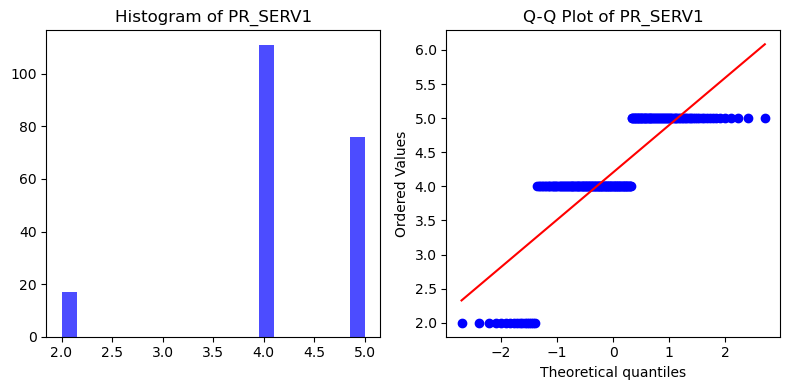

Shapiro-Wilk test for PR_SERV1: Statistic=0.7070, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0., 123.,   0.,   0.,   0.,  63.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of PR_SERV2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of PR_SERV2')

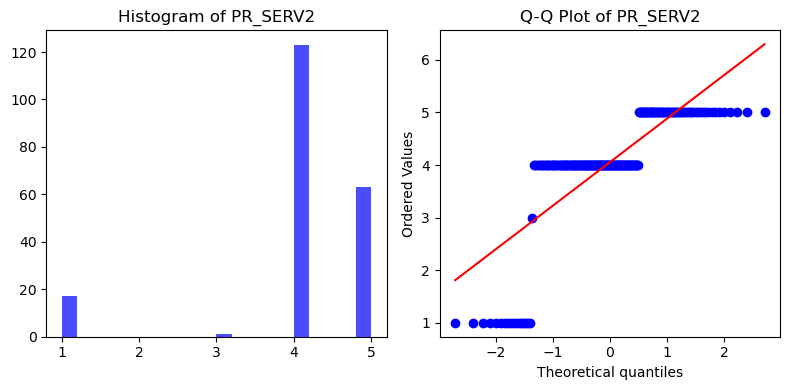

Shapiro-Wilk test for PR_SERV2: Statistic=0.6318, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0., 186.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.  , 2.15, 2.3 , 2.45, 2.6 , 2.75, 2.9 , 3.05, 3.2 , 3.35, 3.5 ,
        3.65, 3.8 , 3.95, 4.1 , 4.25, 4.4 , 4.55, 4.7 , 4.85, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Innov1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Innov1')

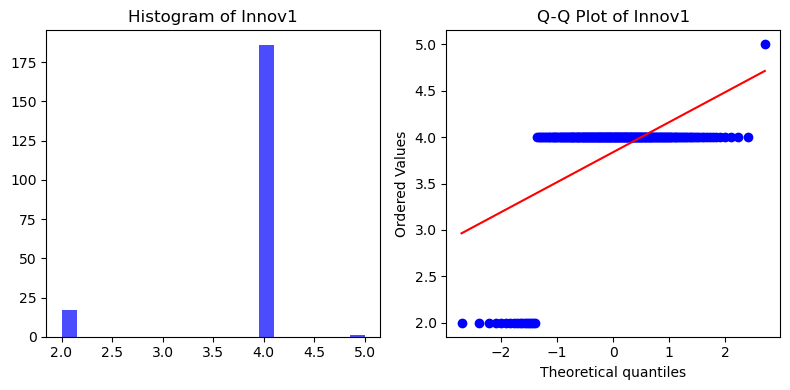

Shapiro-Wilk test for Innov1: Statistic=0.3304, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 185.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Innov2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Innov2')

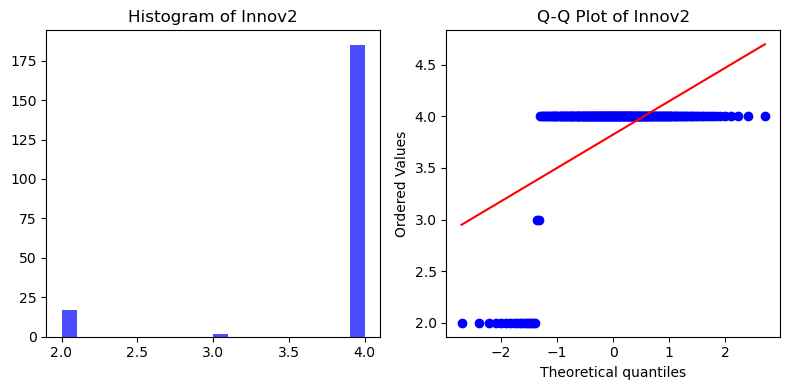

Shapiro-Wilk test for Innov2: Statistic=0.3278, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([203.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 ,
        3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of F1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of F1')

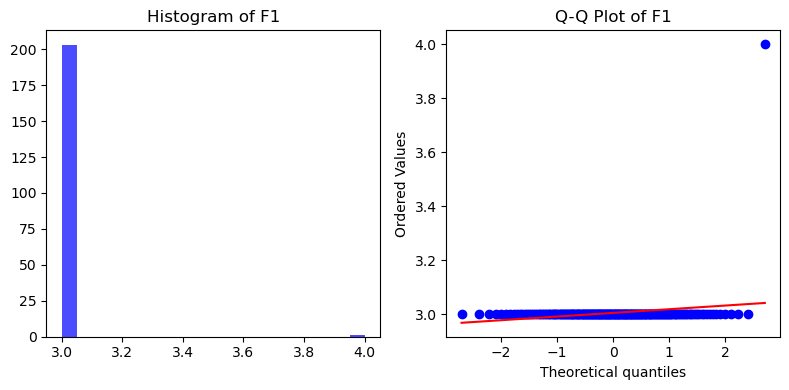

Shapiro-Wilk test for F1: Statistic=0.0434, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([202.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 ,
        3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of F2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of F2')

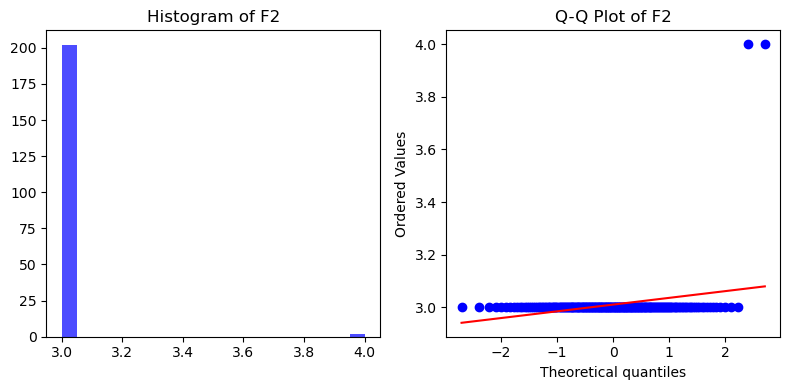

Shapiro-Wilk test for F2: Statistic=0.0726, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 149.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  37.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Sust1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Sust1')

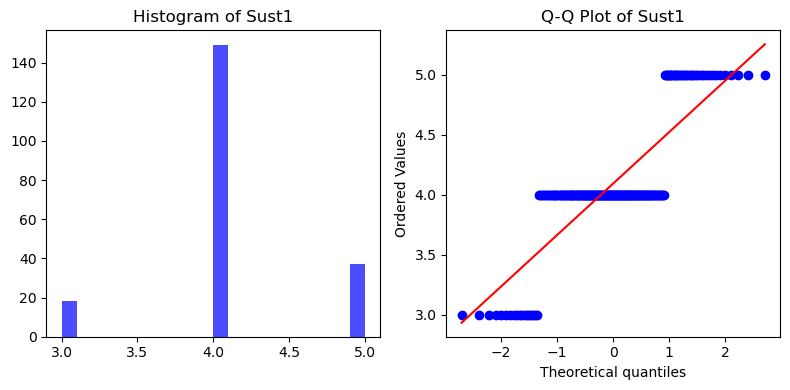

Shapiro-Wilk test for Sust1: Statistic=0.6876, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  83.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 104.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Sust2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Sust2')

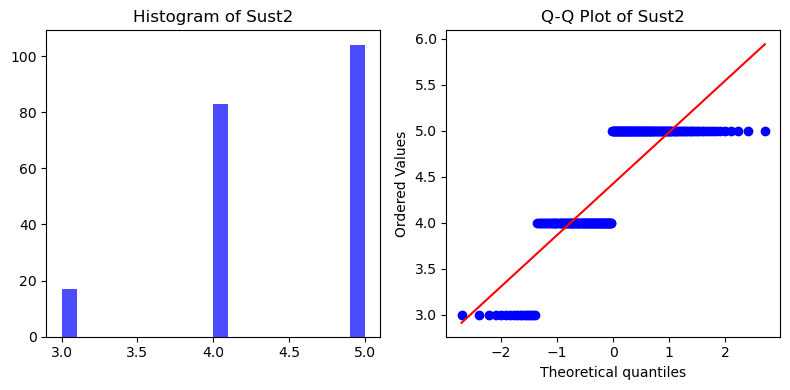

Shapiro-Wilk test for Sust2: Statistic=0.7410, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 11.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 166.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  27.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of W1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of W1')

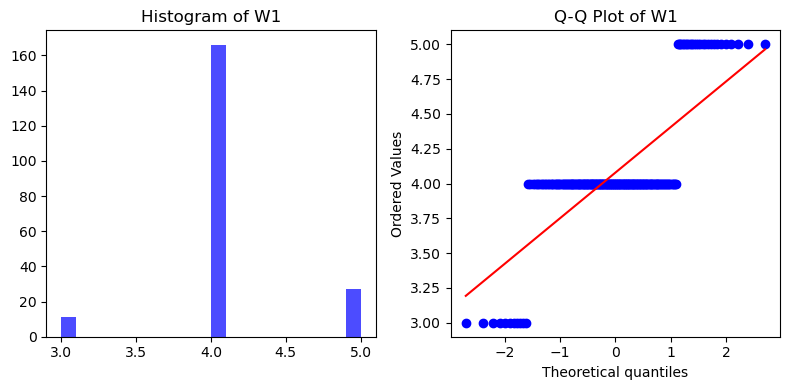

Shapiro-Wilk test for W1: Statistic=0.5816, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([88.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 63.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 53.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of W2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of W2')

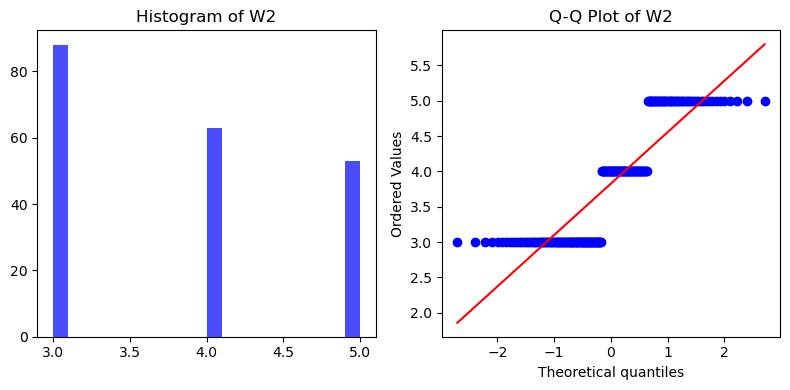

Shapiro-Wilk test for W2: Statistic=0.7772, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([  3.,   0.,   0.,   0.,   0.,  14.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  75.,   0.,   0.,   0., 112.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Cust1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Cust1')

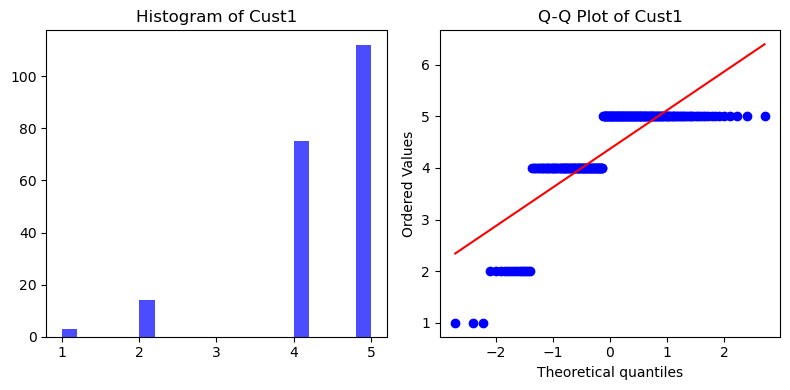

Shapiro-Wilk test for Cust1: Statistic=0.6671, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 17.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 184.]),
 array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
        3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Cust2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Cust2')

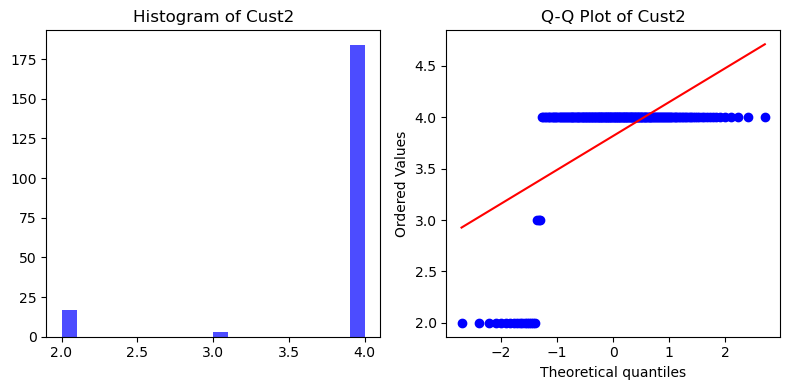

Shapiro-Wilk test for Cust2: Statistic=0.3377, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([201.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 ,
        3.55, 3.6 , 3.65, 3.7 , 3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of VLD1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of VLD1')

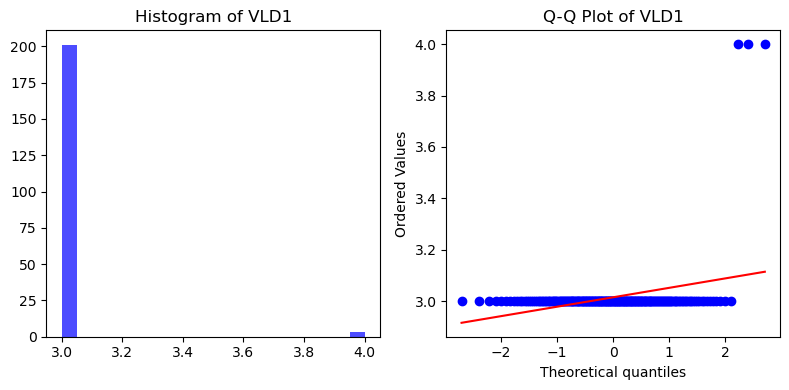

Shapiro-Wilk test for VLD1: Statistic=0.0970, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 6.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 93.,  0.,  0.,  0., 94.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of VLD2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of VLD2')

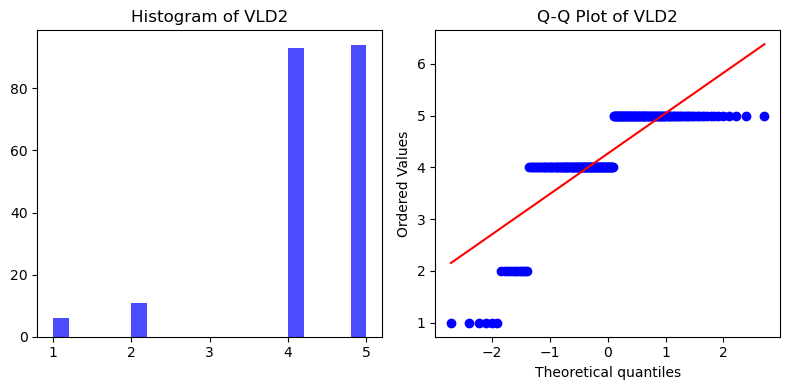

Shapiro-Wilk test for VLD2: Statistic=0.6817, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 31.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 173.]),
 array([4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ,
        4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Trust1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Trust1')

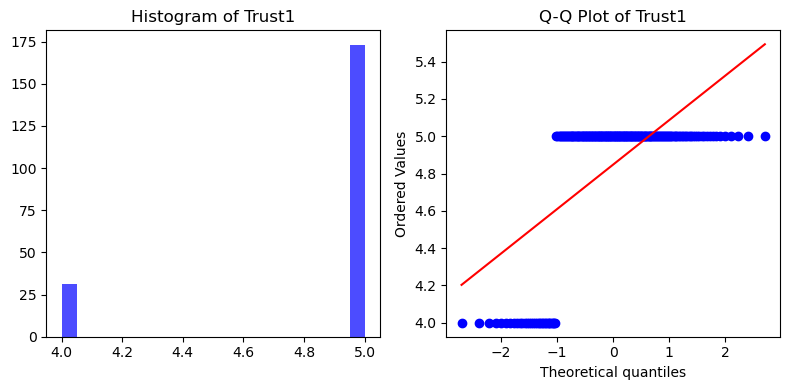

Shapiro-Wilk test for Trust1: Statistic=0.4290, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 182.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  21.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Trust2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Trust2')

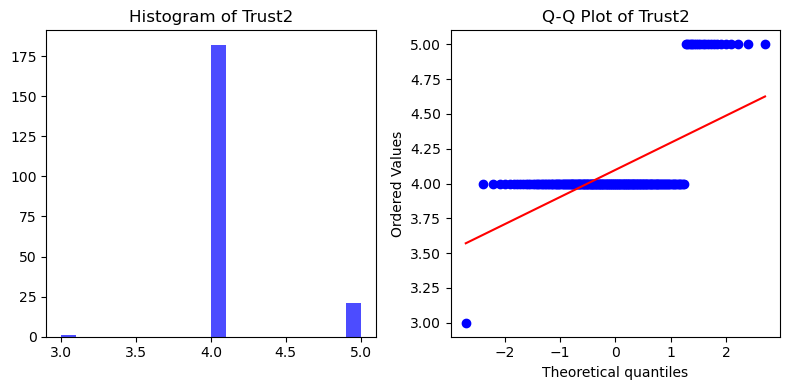

Shapiro-Wilk test for Trust2: Statistic=0.3821, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 21.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 183.]),
 array([4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ,
        4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Trust3')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Trust3')

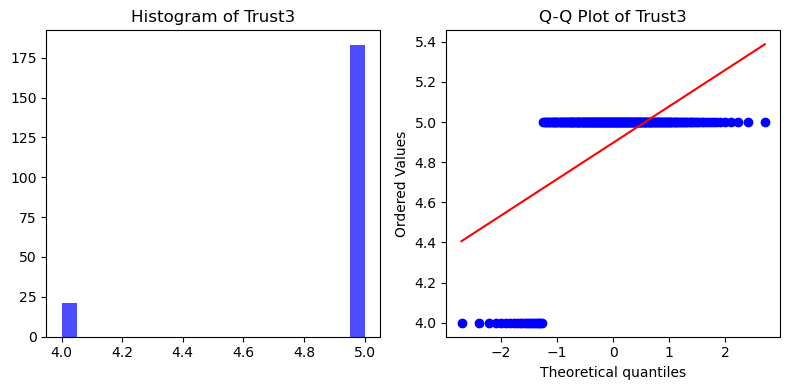

Shapiro-Wilk test for Trust3: Statistic=0.3477, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 43.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 161.]),
 array([4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ,
        4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Resp1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Resp1')

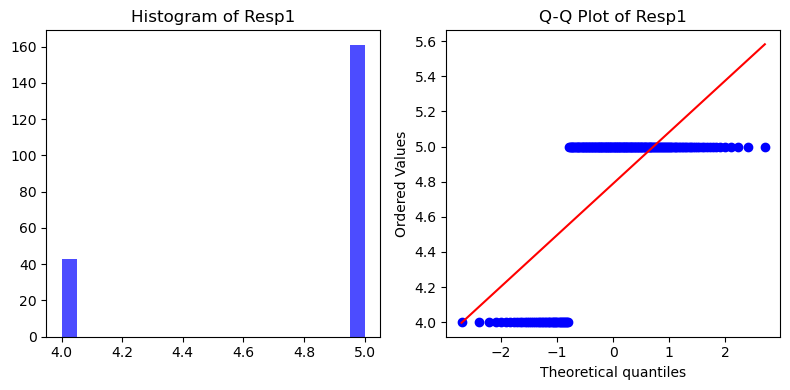

Shapiro-Wilk test for Resp1: Statistic=0.5012, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([ 12.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  32.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 160.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of EWOM1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of EWOM1')

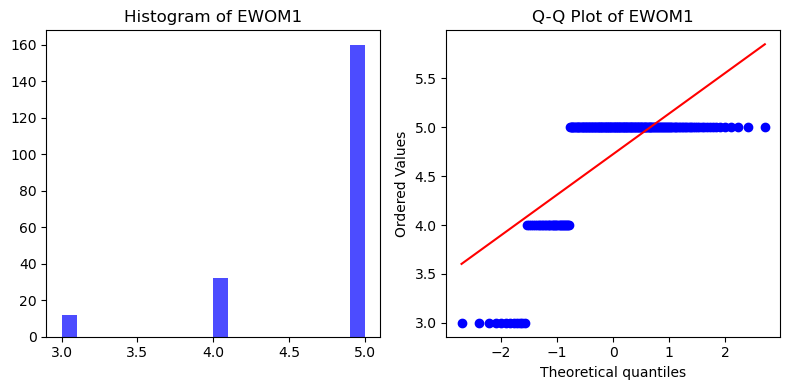

Shapiro-Wilk test for EWOM1: Statistic=0.5305, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([142.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  62.]),
 array([4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25, 4.3 , 4.35, 4.4 , 4.45, 4.5 ,
        4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 , 4.85, 4.9 , 4.95, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of EWOM2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of EWOM2')

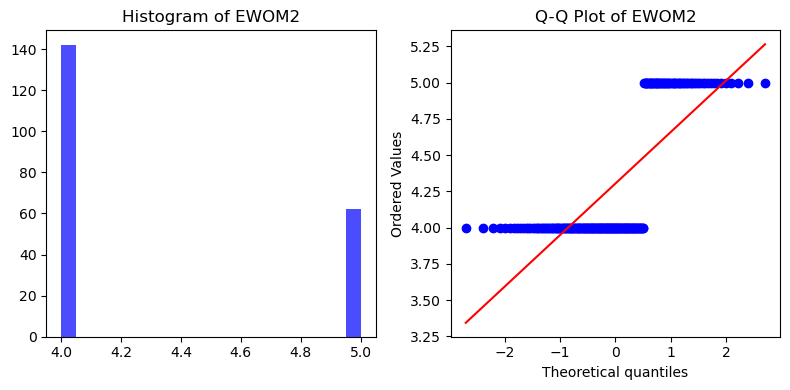

Shapiro-Wilk test for EWOM2: Statistic=0.5779, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  49.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 154.]),
 array([3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2,
        4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Decis1')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Decis1')

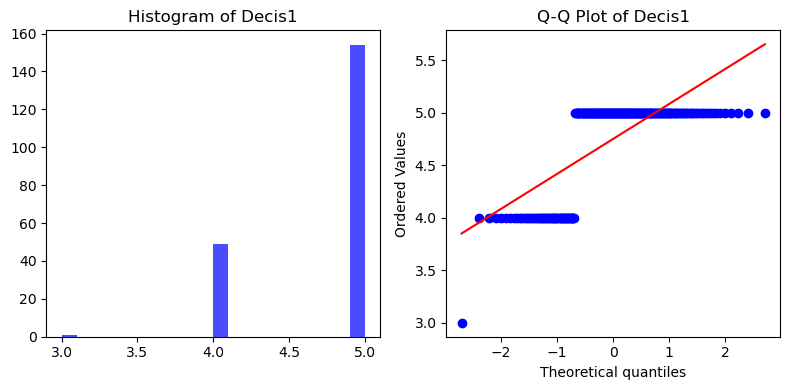

Shapiro-Wilk test for Decis1: Statistic=0.5483, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  87.,   0.,   0.,   0.,   0.,   0., 116.]),
 array([2.  , 2.15, 2.3 , 2.45, 2.6 , 2.75, 2.9 , 3.05, 3.2 , 3.35, 3.5 ,
        3.65, 3.8 , 3.95, 4.1 , 4.25, 4.4 , 4.55, 4.7 , 4.85, 5.  ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Decis2')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Decis2')

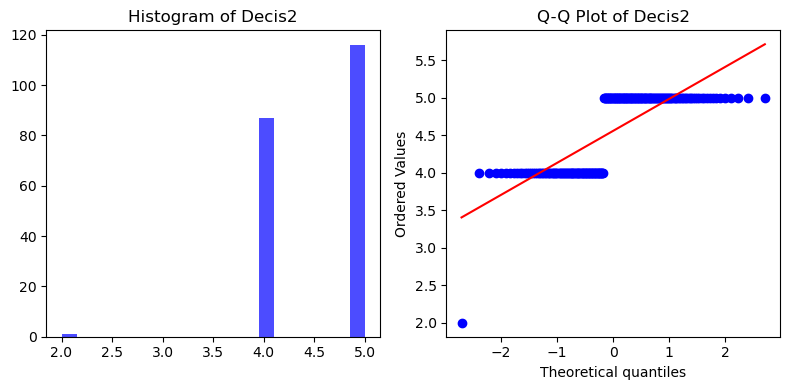

Shapiro-Wilk test for Decis2: Statistic=0.6455, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  54.,   0.,   0.,   0., 149.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <BarContainer object of 20 artists>)

Text(0.5, 1.0, 'Histogram of Decis3')

<Axes: >

((array([-2.70726399, -2.39842746, -2.22246275, -2.09649322, -1.99700286,
         -1.91406944, -1.84252978, -1.77933957, -1.72254677, -1.67082155,
         -1.62321552, -1.57902748, -1.53772379, -1.49888844, -1.4621906 ,
         -1.42736262, -1.39418479, -1.36247439, -1.33207777, -1.30286444,
         -1.27472256, -1.24755554, -1.22127932, -1.1958203 , -1.17111364,
         -1.14710188, -1.12373391, -1.10096397, -1.07875099, -1.0570579 ,
         -1.03585119, -1.01510037, -0.9947777 , -0.97485779, -0.95531738,
         -0.9361351 , -0.91729125, -0.89876761, -0.88054735, -0.86261482,
         -0.84495549, -0.82755582, -0.81040314, -0.79348566, -0.77679228,
         -0.76031261, -0.74403689, -0.72795592, -0.71206104, -0.69634405,
         -0.68079723, -0.66541324, -0.65018516, -0.63510638, -0.62017064,
         -0.60537198, -0.59070474, -0.57616348, -0.56174305, -0.5474385 ,
         -0.53324511, -0.51915833, -0.50517384, -0.49128745, -0.47749516,
         -0.46379311, -0.4501776 , -0.

Text(0.5, 1.0, 'Q-Q Plot of Decis3')

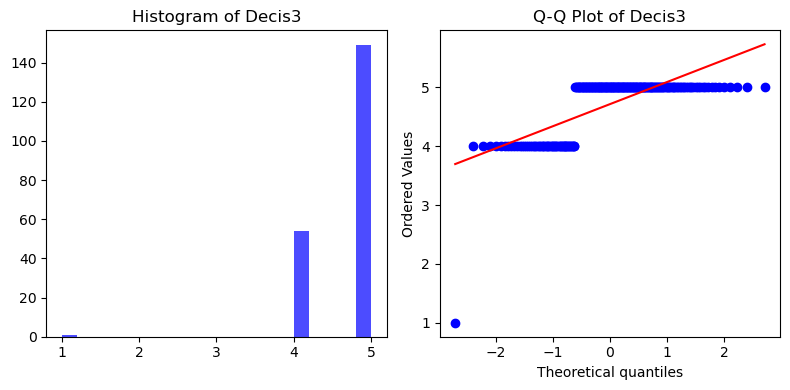

Shapiro-Wilk test for Decis3: Statistic=0.5332, p-value=0.0000


<Figure size 800x400 with 0 Axes>

<Axes: >

Text(0.5, 0, 'CorpRep')

Text(0, 0.5, 'Decis1')

Text(0.5, 1.0, 'Scatter Plot: CorpRep vs Decis1')

<Axes: >

Text(0.5, 0, 'CorpRep')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot: CorpRep vs Residuals')

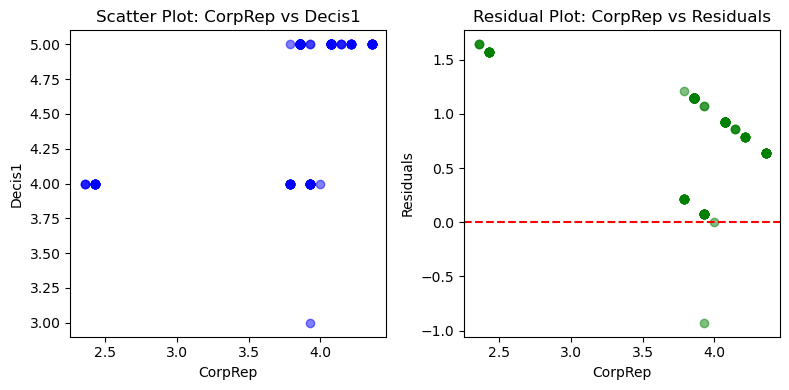

<Figure size 800x400 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Trust')

Text(0, 0.5, 'Decis1')

Text(0.5, 1.0, 'Scatter Plot: Trust vs Decis1')

<Axes: >

Text(0.5, 0, 'Trust')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot: Trust vs Residuals')

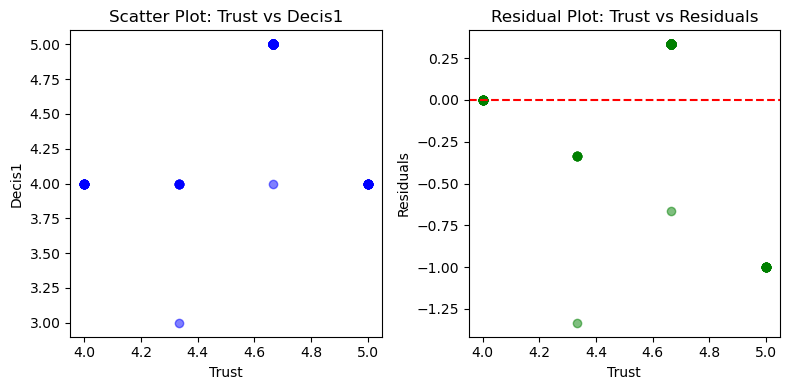

<Figure size 800x400 with 0 Axes>

<Axes: >

Text(0.5, 0, 'eWOM')

Text(0, 0.5, 'Decis1')

Text(0.5, 1.0, 'Scatter Plot: eWOM vs Decis1')

<Axes: >

Text(0.5, 0, 'eWOM')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot: eWOM vs Residuals')

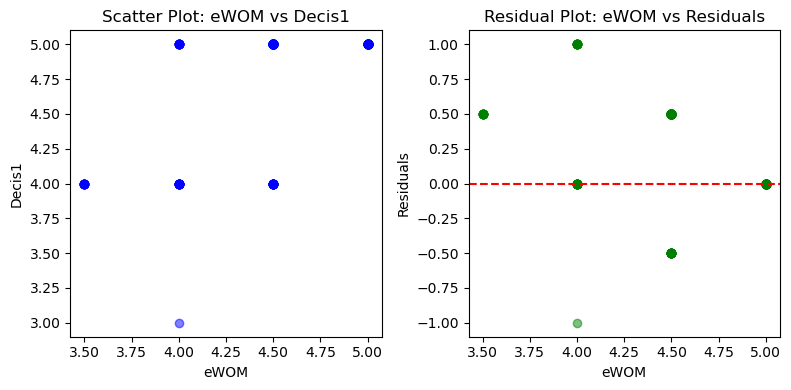

<Figure size 800x400 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Responsiveness')

Text(0, 0.5, 'Decis1')

Text(0.5, 1.0, 'Scatter Plot: Responsiveness vs Decis1')

<Axes: >

Text(0.5, 0, 'Responsiveness')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot: Responsiveness vs Residuals')

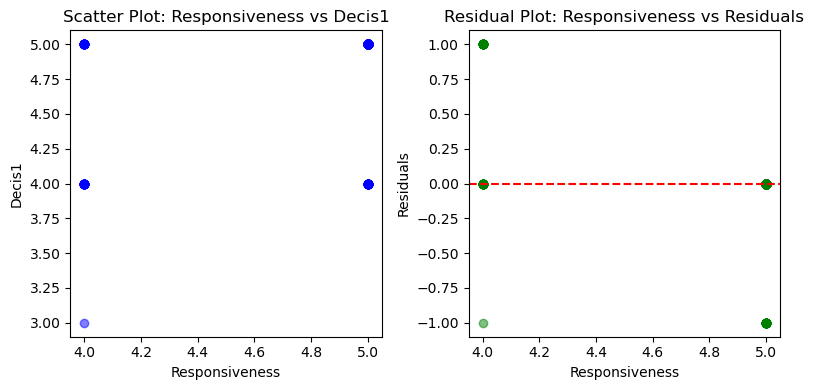

<Figure size 800x400 with 0 Axes>

<Axes: >

Text(0.5, 0, 'Decision_Making')

Text(0, 0.5, 'Decis1')

Text(0.5, 1.0, 'Scatter Plot: Decision_Making vs Decis1')

<Axes: >

Text(0.5, 0, 'Decision_Making')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residual Plot: Decision_Making vs Residuals')

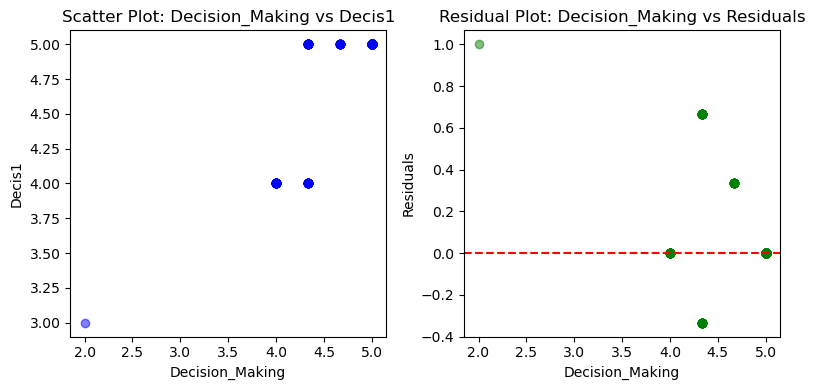

In [628]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats



# Select relevant columns for analysis
observed_vars = ['PR_SERV1', 'PR_SERV2', 'Innov1', 'Innov2', 'F1', 'F2', 'Sust1', 'Sust2', 'W1', 'W2',
                 'Cust1', 'Cust2', 'VLD1', 'VLD2', 'Trust1', 'Trust2', 'Trust3', 'Resp1','EWOM1', 'EWOM2', 'Decis1', 'Decis2', 'Decis3']

# Check for Normality
for var in observed_vars:
    plt.figure(figsize=(8, 4))
    
    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(data[var], bins=20, color='blue', alpha=0.7)
    plt.title(f'Histogram of {var}')
    
    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(data[var], plot=plt)
    plt.title(f'Q-Q Plot of {var}')
    
    plt.tight_layout()
    plt.show()
    
    # Shapiro-Wilk Test
    stat, p = stats.shapiro(data[var])
    print(f'Shapiro-Wilk test for {var}: Statistic={stat:.4f}, p-value={p:.4f}')

# Check for Linearity
relationship_vars = ['CorpRep', 'Trust', 'eWOM', 'Responsiveness', 'Decision_Making']

for var in relationship_vars:
    plt.figure(figsize=(8, 4))
    
    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(data[var], data['Decis1'], color='blue', alpha=0.5)
    plt.xlabel(var)
    plt.ylabel('Decis1')
    plt.title(f'Scatter Plot: {var} vs Decis1')
    
    # Residual Plot
    plt.subplot(1, 2, 2)
    residuals = data['Decis1'] - data[var]
    plt.scatter(data[var], residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel(var)
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot: {var} vs Residuals')
    
    plt.tight_layout()
    plt.show()
